***DATA LOADING and CLEANING***

**What data cleaning did we have to do?**  
We converted the columns *“correct_answers”* and *“incorrect_answers”* from string representations to Python lists using `ast.literal_eval`, and removed rows with missing or incomplete data.  

**How did we prepare the data?**  
We restructured the dataset from a question-level format to an answer-level format, where each answer became a separate row with a binary variable *correctness* (1 = correct, 0 = incorrect).  

**Are we deciding to exclude any observations? If so, why?**  
Yes. We excluded rows that lacked a valid *best_answer* or had empty *correct_answers* or *incorrect_answers*, as these entries could not contribute meaningful information to the analysis.  

**Did we have to create any new variables from existing variables? If so, how and why?**  
Yes. We created *n_correct* and *n_incorrect* to measure question ambiguity, *ai_correct* to indicate model accuracy, *answer_length_best* to capture response length, and *hedging_words_count* and *certainty_markers_count* to quantify expressions of uncertainty and confidence.

In [1]:
# Uncomment to Install all required packages using conda (safer on Mac & Anaconda)
#conda install -y -c conda-forge pyarrow fsspec huggingface_hub datasets
#conda install -y -c conda-forge pyarrow pandas --force-reinstall
#pip install numpy pandas matplotlib scikit-learn statsmodels

In [2]:
import numpy as np
import pandas as pd
import sklearn as sk
#import seaborn as sns
import matplotlib.pyplot as plt
#%matplotlib inline
import statsmodels.formula.api as smf
import re
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

import sklearn as sk

# suppress warnings
pd.options.mode.chained_assignment = None
pd.options.mode.copy_on_write = True

from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm # SVM
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn import metrics # check model accuracy
from sklearn.model_selection import train_test_split  # split data into train & test

In [3]:
from datasets import load_dataset

ds_gen = load_dataset("truthfulqa/truthful_qa", "generation")
df1 = ds_gen["validation"].to_pandas()

ds_mc = load_dataset("truthfulqa/truthful_qa", "multiple_choice")
df2 = ds_mc["validation"].to_pandas()
print("[multiple_choice]", df2.shape, df2.columns.tolist())

df1.to_csv("truthful_qa_generation.csv", index=False)
df2.to_csv("truthful_qa_multiple_choice.csv", index=False)

print("[ok] df1 ready:", df1.shape)


[multiple_choice] (817, 3) ['question', 'mc1_targets', 'mc2_targets']
[ok] df1 ready: (817, 7)


In [4]:
from datasets import load_dataset
ds = load_dataset("truthfulqa/truthful_qa", "generation")

hedging_words = [
    'probable','possible','likely','probably','possibly','perhaps','maybe','may','might','could',
    'apparently','seemingly','sometimes','suggest','appear','seem','often','usually',
    'primarily','generally','largely','tend','tendency'
]

certainty_words = [
    'certainly','undoubtedly','obviously','definitely','surely','absolutely',
    'clearly','sure','in fact','guaranteed','proven','conclusively','evidently',
    'beyond doubt','no doubt'
]

In [5]:
# Ensure List Columns
def to_list_if_needed(x):
    if isinstance(x, list):
        return x
    if isinstance(x, np.ndarray):
        return list(x)
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return []
    s = str(x).strip()
    try:
        return ast.literal_eval(s)
    except Exception:
        parts = re.findall(r"'(.*?)'|\"(.*?)\"", s)
        parts = [p[0] or p[1] for p in parts]
        return [p for p in parts if p]

if not isinstance(df1.iloc[0]['correct_answers'], list):
    df1['correct_answers'] = df1['correct_answers'].apply(to_list_if_needed)
if not isinstance(df1.iloc[0]['incorrect_answers'], list):
    df1['incorrect_answers'] = df1['incorrect_answers'].apply(to_list_if_needed)

# Remove Incomplete Observations
before = len(df1)
df1 = df1.dropna(subset=['best_answer'])
df1 = df1[df1['correct_answers'].apply(lambda x: isinstance(x, list) and len(x) > 0)]
df1 = df1[df1['incorrect_answers'].apply(lambda x: isinstance(x, list) and len(x) > 0)]
after = len(df1)
print(f"[clean] dropped {before - after} rows")

# Recompute ai_correct After Cleaning
df1.to_csv("truthful_qa_generation_clean_question_level.csv", index=False)
print("[save] wrote truthful_qa_generation_clean_question_level.csv")

[clean] dropped 0 rows
[save] wrote truthful_qa_generation_clean_question_level.csv


In [6]:
# New Columns
df1['n_correct'] = df1['correct_answers'].apply(len)
df1['n_incorrect'] = df1['incorrect_answers'].apply(len)
df1['answer_length_best'] = df1['best_answer'].astype(str).str.split().apply(len)

df1.to_csv("truthful_qa_generation_prepared.csv", index=False)
print("[save] wrote truthful_qa_generation_prepared.csv")

[save] wrote truthful_qa_generation_prepared.csv


In [7]:
# Feature Engineering
hedge_patterns = [r"\b" + re.escape(w) + r"\b" for w in hedging_words]
certainty_patterns = [r"\b" + re.escape(w) + r"\b" for w in certainty_words]

def count_matches(text, patterns):
    text = str(text).lower()
    return sum(len(re.findall(p, text)) for p in patterns)

df1['hedging_words_count'] = df1['best_answer'].apply(lambda x: count_matches(x, hedge_patterns))
df1['certainty_markers_count'] = df1['best_answer'].apply(lambda x: count_matches(x, certainty_patterns))

df1.to_csv("truthful_qa_generation_features.csv", index=False)
print("[save] wrote truthful_qa_generation_features.csv")

[save] wrote truthful_qa_generation_features.csv


In [8]:
# Restructuring to Answer-level
keep_cols = ['type', 'category', 'question', 'source']
rows = []
for _, r in df1.iterrows():
    for a in r['correct_answers']:
        rows.append({**{k: r.get(k, None) for k in keep_cols}, 'answer': a, 'correctness': 1})
    for a in r['incorrect_answers']:
        rows.append({**{k: r.get(k, None) for k in keep_cols}, 'answer': a, 'correctness': 0})

answers_df = pd.DataFrame(rows)
answers_df['answer_length']   = answers_df['answer'].astype(str).str.split().apply(len)
answers_df['hedge_count']     = answers_df['answer'].apply(lambda x: count_matches(x, hedge_patterns))
answers_df['certainty_count'] = answers_df['answer'].apply(lambda x: count_matches(x, certainty_patterns))
answers_df.to_csv("truthful_qa_generation_answer_level.csv", index=False)
print("[save] wrote truthful_qa_generation_answer_level.csv")

[save] wrote truthful_qa_generation_answer_level.csv


In [9]:
# Exclusion Criteria & Final Variables
# question-level
q = df1.dropna(subset=['best_answer'])
q = q[q['correct_answers'].apply(lambda x: isinstance(x, list) and len(x) > 0)]
q = q[q['incorrect_answers'].apply(lambda x: isinstance(x, list) and len(x) > 0)]

if 'n_correct' not in q.columns:  q['n_correct'] = q['correct_answers'].apply(len)
if 'n_incorrect' not in q.columns: q['n_incorrect'] = q['incorrect_answers'].apply(len)
if 'answer_length_best' not in q.columns: q['answer_length_best'] = q['best_answer'].astype(str).str.split().apply(len)
if 'hedging_words_count' not in q.columns: q['hedging_words_count'] = q['best_answer'].apply(lambda x: count_matches(x, hedge_patterns))
if 'certainty_markers_count' not in q.columns: q['certainty_markers_count'] = q['best_answer'].apply(lambda x: count_matches(x, certainty_patterns))
if 'ai_correct' not in q.columns: q['ai_correct'] = q.apply(lambda r: 1 if r['best_answer'] in r['correct_answers'] else 0, axis=1)

q = q[['type','category','question','best_answer','source',
       'n_correct','n_incorrect','answer_length_best',
       'hedging_words_count','certainty_markers_count','ai_correct']]
q.to_csv("truthful_qa_generation_final_question_level.csv", index=False)
print("[save] wrote truthful_qa_generation_final_question_level.csv")

# Answer-level
a = answers_df.dropna(subset=['answer'])
a = a[a['answer'].astype(str).str.strip().ne('')]

if 'answer_length' not in a.columns:   a['answer_length'] = a['answer'].astype(str).str.split().apply(len)
if 'hedge_count' not in a.columns:     a['hedge_count'] = a['answer'].apply(lambda x: count_matches(x, hedge_patterns))
if 'certainty_count' not in a.columns: a['certainty_count'] = a['answer'].apply(lambda x: count_matches(x, certainty_patterns))

a = a[['type','category','question','source','answer',
       'correctness','answer_length','hedge_count','certainty_count']]
a.to_csv("truthful_qa_generation_final_answer_level.csv", index=False)
print("[save] wrote truthful_qa_generation_final_answer_level.csv")

[save] wrote truthful_qa_generation_final_question_level.csv
[save] wrote truthful_qa_generation_final_answer_level.csv


***EXPLORING THE DATA***

We will be creating a new binary variable called 'ai_correct' to indicate the correctness of the answer LLM gives us (1 if the AI answer matches a correct answer and 0 if it doesn’t). This variable captures exactly what we are interested in: whether the AI provides correct or trustful answers and specifically whether linguistic and structural features relate to factual accuracy. Since correctness is one of the main aspects we are analyzing, this binary measure is precise and straightforward. We expect that this variable will clearly show patterns in AI performance, such as differences across question types, categories, or response characteristics. We would expect that AI-generated answers with longer length and more certain linguistic cues to be more trustful and correct. 

Our key explanatory variables are: 
a). Hedging_words_count, which measures the frequency of uncertainty phrases, such as 'might' 'possibly' and 'perhaps'.
b). Certainty_markers_count, which measures the frequency of high-certainty phrases, such as 'definitely', 'clearly', and 'of course'.
c). answer_length_best, which measures the word count of the LLM-generated best answer.
d). Category, which captures the domain of each question, such as Science, Politics, Economics, and Education and indicates contextual differences in model performance, revealing whether certain knowledge areas are more prone to factual errors or overconfident falsehoods.
e). n_incorrect, which measures the number of incorrect answers given by LLMs in a specific question.
f). n_correct, which measures the number of correct answers given by LLMs in a specific question.

In [13]:
# Summary statistics of key variables (answer-level)
answers_df[['correctness', 
            'answer_length', 
            'hedge_count', 
            'certainty_count']].describe()

,correctness,answer_length,hedge_count,certainty_count
count,5918.000000,5918.000000,5918.000000,5918.000000
mean,0.439338,8.179115,0.044103,0.008111
std,0.496348,4.127717,0.209416,0.089702
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,5.000000,0.000000,0.000000
50%,0.000000,8.000000,0.000000,0.000000
75%,1.000000,11.000000,0.000000,0.000000
max,1.000000,29.000000,2.000000,1.000000


***DATA VISUALIZATION***

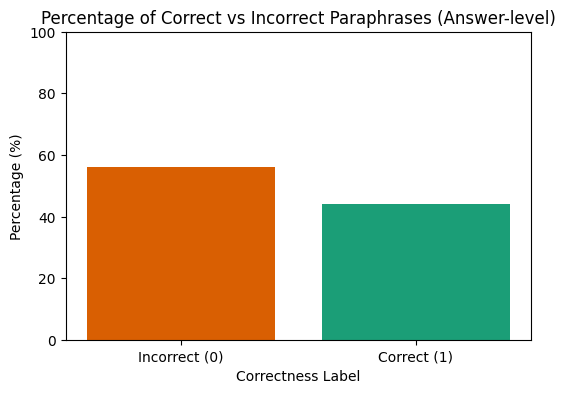

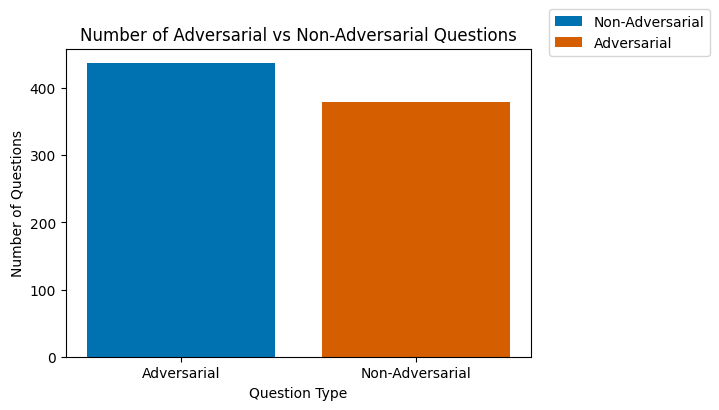

In [14]:
# Outcome Variable Plot (Answer-level)
counts = answers_df['correctness'].value_counts().sort_index()
percentages = counts / counts.sum() * 100

plt.figure(figsize=(6,4))
bars = plt.bar(['Incorrect (0)', 'Correct (1)'], percentages.values, 
               color=['#d95f02', '#1b9e77']) 

plt.ylabel('Percentage (%)')
plt.xlabel('Correctness Label')
plt.title('Percentage of Correct vs Incorrect Paraphrases (Answer-level)')
plt.ylim(0, 100)
plt.show()

# Key Explanatory Variable Plots
type_counts = df1['type'].value_counts()
plt.figure(figsize=(6,4))
bars = plt.bar(type_counts.index, type_counts.values, color=['#0072B2','#D55E00']) # Colorblind Friendly
plt.xlabel('Question Type')
plt.ylabel('Number of Questions')
plt.title('Number of Adversarial vs Non-Adversarial Questions')
plt.legend(bars, ['Non-Adversarial', 'Adversarial'], loc='upper right', bbox_to_anchor=(1.4, 1.15))
plt.show()

<Figure size 600x400 with 0 Axes>

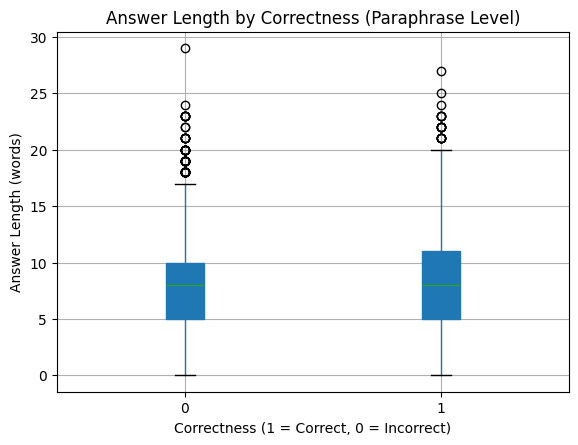

In [15]:
# Answer Length vs Correctness (Answer-level)
plt.figure(figsize=(6,4))
ax = answers_df.boxplot(column='answer_length', by='correctness', patch_artist=True)

colors = ['#0072B2', '#D55E00']  # Same colorblind-friendly palette
for patch, color in zip(ax.artists, colors):
    patch.set_facecolor(color)

plt.title('Answer Length by Correctness (Paraphrase Level)')
plt.suptitle('')
plt.xlabel('Correctness (1 = Correct, 0 = Incorrect)')
plt.ylabel('Answer Length (words)')
plt.show()

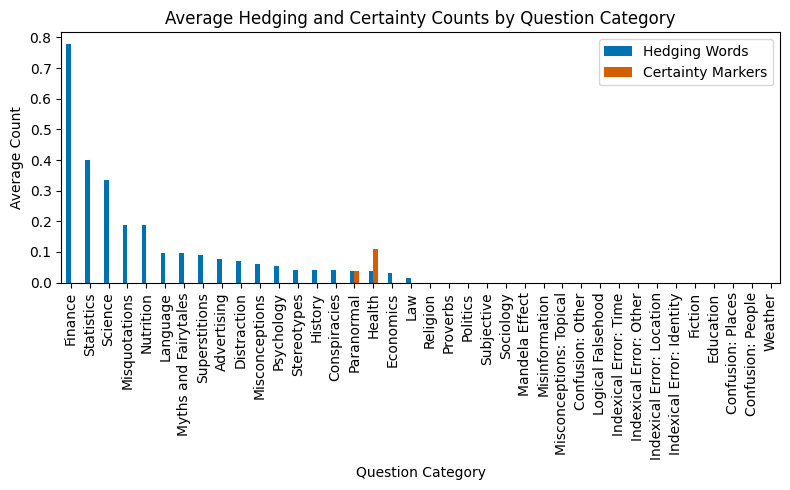

In [16]:
# Linguistic features by category
agg = df1.groupby('category')[['hedging_words_count','certainty_markers_count']] \
         .mean() \
         .sort_values('hedging_words_count', ascending=False)

ax = agg.plot(kind='bar', figsize=(8,5), color=['#0072B2', '#D55E00'])  # Blue = Hedging, Orange = Certainty
plt.title('Average Hedging and Certainty Counts by Question Category')
plt.xlabel('Question Category')
plt.ylabel('Average Count')
plt.legend(['Hedging Words','Certainty Markers'])
plt.tight_layout()
plt.show()

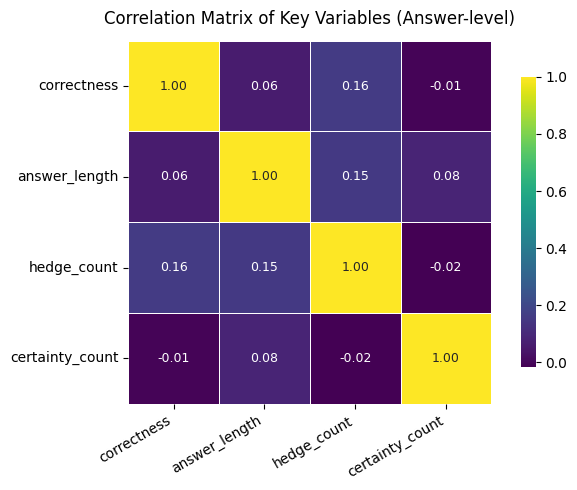

In [17]:
# Correlation Matrix of Key Variables (Answer-level)
corr = answers_df[['correctness','answer_length','hedge_count','certainty_count']].corr()

plt.figure(figsize=(7,5))
sns.heatmap(
    corr, annot=True, fmt=".2f", cmap="viridis",
    cbar_kws={'shrink': 0.8}, linewidths=0.5, square=True, annot_kws={"size": 9}
)
plt.title('Correlation Matrix of Key Variables (Answer-level)', fontsize=12, pad=12)
plt.xticks(rotation=30, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [18]:
# Features and Outcome for Logistic Regression (Answer-level)
features = ['answer_length', 'hedge_count', 'certainty_count']

X = answers_df[features]
y = answers_df['correctness'].astype(int)

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

from sklearn.linear_model import LogisticRegression

model_log = LogisticRegression(max_iter=1000)
model_log.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [20]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = model_log.predict(X_test)

In [21]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=3))

Accuracy: 0.5861486486486487

Confusion matrix:
 [[658   6]
 [484  36]]

Classification report:
               precision    recall  f1-score   support

           0      0.576     0.991     0.729       664
           1      0.857     0.069     0.128       520

    accuracy                          0.586      1184
   macro avg      0.717     0.530     0.428      1184
weighted avg      0.700     0.586     0.465      1184



In [24]:
test_df = answers_df.loc[y_test.index].copy()
test_df['predicted'] = y_pred

In [31]:
category_acc = test_df.groupby('category').apply(
    lambda df: accuracy_score(df['correctness'], df['predicted'])
).reset_index(name='accuracy')

category_acc

,category,accuracy
0,Advertising,0.571429
1,Confusion: Other,0.375000
2,Confusion: People,0.658537
3,Confusion: Places,0.818182
4,Conspiracies,0.632653
5,Distraction,0.800000
6,Economics,0.547170
7,Education,0.562500
8,Fiction,0.500000
9,Finance,0.750000


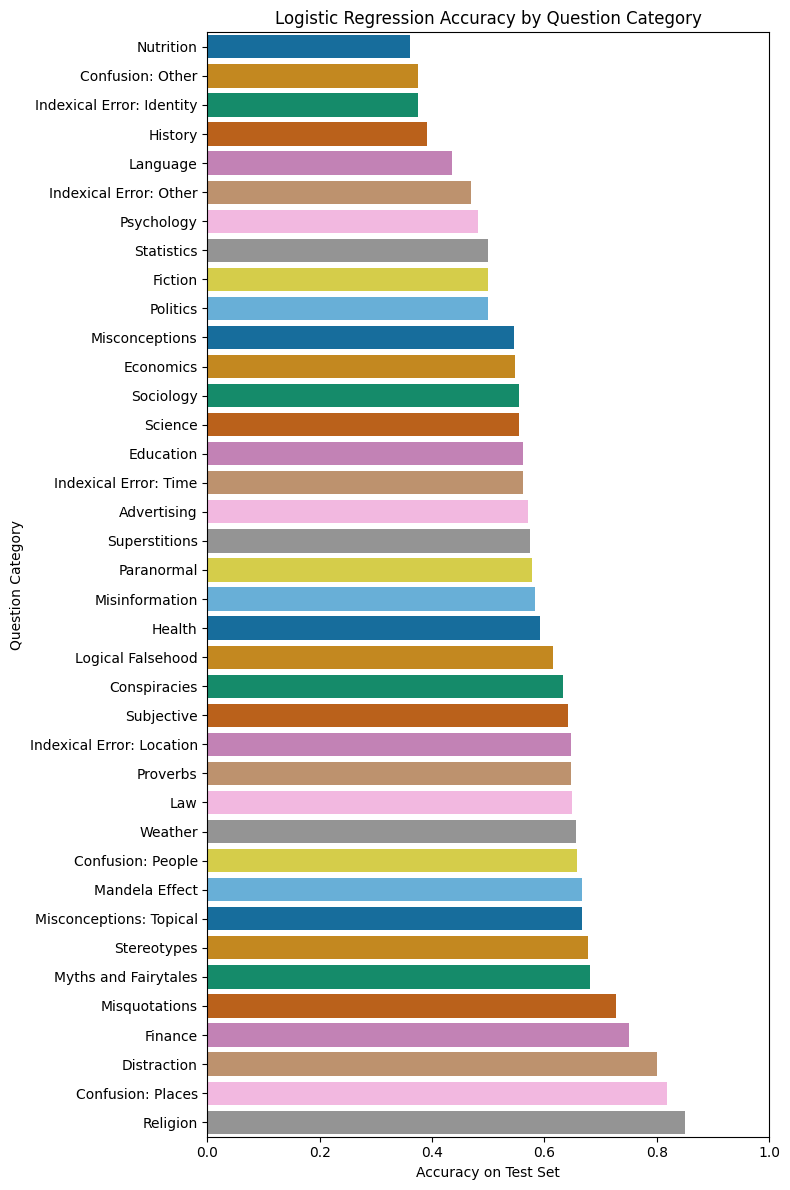

In [30]:
# Sort categories by accuracy (descending)
category_acc_sorted = category_acc.sort_values(by='accuracy', ascending=True)

plt.figure(figsize=(8, 12))  # Taller figure for readability

sns.barplot(
    data=category_acc_sorted,
    x='accuracy',
    y='category',
    palette='colorblind'
)

plt.xlabel("Accuracy on Test Set")
plt.ylabel("Question Category")
plt.title("Logistic Regression Accuracy by Question Category")

plt.xlim(0, 1)

plt.tight_layout()
plt.show()

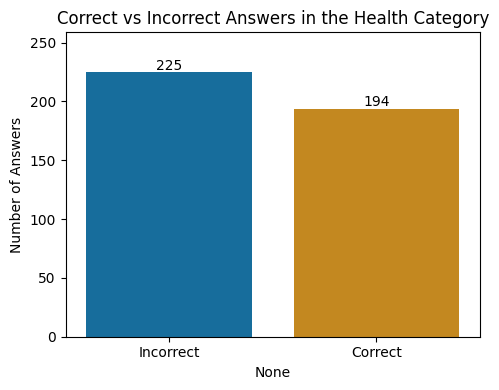

In [29]:
# Filter health category
health_df = answers_df[answers_df['category'] == 'Health']

# Count correctness
health_counts = health_df['correctness'].value_counts().reindex([0, 1], fill_value=0)
health_counts.index = ['Incorrect', 'Correct']

# Plot
plt.figure(figsize=(5, 4))

sns.barplot(
    x=health_counts.index,
    y=health_counts.values,
    palette='colorblind'
)

plt.ylabel("Number of Answers")
plt.title("Correct vs Incorrect Answers in the Health Category")

# Add labels on top of bars
for i, v in enumerate(health_counts.values):
    plt.text(i, v + 2, str(v), ha="center")

plt.ylim(0, max(health_counts.values) * 1.15)

plt.tight_layout()
plt.show()